# Volume 3: ARMA Models
Matthew Mella

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd

## Helper Functions

In [2]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F,F), 
            np.eye(dim_states**2) @ Q.flatten()).reshape((dim_states,dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        # Assume u, R = 0
        SkInv = np.linalg.solve(H @ covs[i-1] @ H.T, np.eye(H.shape[0]))
        Kk_H_Pkk = covs[i-1] @ (H.T @ (SkInv @ (H @ covs[i-1])))
        covs[i] = F @ ((covs[i-1] - Kk_H_Pkk) @ F.T) + Q
        mus[i] = F @ mus[i-1] + (F @ (covs[i-1] @ (H.T @ SkInv))) @ (time_series[i-1] - H @ mus[i-1])
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 #hardcoded for 1d time_series

    F = np.zeros((dim_states,dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0,:len(phis)] = phis
    F[1:,:-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

## Problem 1

In [3]:
def arma_forecast_naive(file='weather.npy',p=2,q=1,n=20):
    """
    Perform ARMA(p,q) on data. Let error terms be drawn from
    a standard normal, let c be 0, the phis be 0.5, and the 
    thetas be 0.1. Predict the next n observations and plot 
    the original data with the predictions.

    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    # load data
    data = np.load(file)
    x = np.arange(len(data))

    diff_data = np.diff(data)

    # set parameters
    c = 0
    phi = 0.5
    theta = 0.1
    eps = np.random.normal(0,1,len(data))

    # create n observations
    for i in range(n):
        # create AR and MA terms
        ar = [diff_data[-j] * phi for j in range(1,p+1)]
        ma = [eps[j] * theta for j in range(1,q+1)]

        # append new observation
        diff_data = np.append(diff_data, c + np.sum(ar) + np.sum(ma) + eps[-1])

    return diff_data


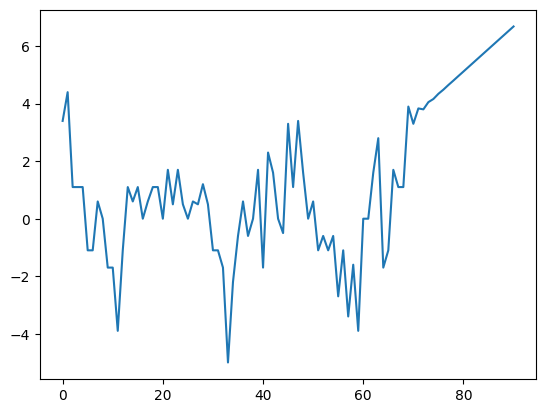

In [4]:
diff_data = arma_forecast_naive()

# plot
plt.plot(diff_data)
plt.show()


## Problem 2

In [5]:
def arma_likelihood(filename='weather.npy', phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of error
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """
    # Load data
    data = np.load(filename)

    # Get differences
    data_diff = np.diff(data)

    # Get state space representation
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)

    # Run Kalman Filter
    x_array, covs = kalman(F, Q, H, data_diff - mu)


    # Calculate likelihood
    log_likelihood = 0
    for i in range(len(data_diff)):
        log_likelihood += norm.logpdf(data_diff[i], H @ x_array[i] + mu, np.sqrt(H @ covs[i] @ H.T))[0][0]

    return log_likelihood

In [6]:
arma_likelihood(filename='weather.npy', phis=np.array([0.9]),
                    thetas=np.array([0]), mu=17., std=0.4)

-1375.1805469978774

## Problem 3

In [15]:
def model_identification(filename='weather.npy',p_max=4,q_max=4):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    # load the time series
    time_series = np.diff(np.load(filename))

    best_aic = np.inf
    best_sol = None
    best_p = 0
    best_q = 0
    for p in range(1, p_max + 1):
        for q in range(1, q_max + 1):
            # assume p, q, and time_series are defined
            def f(x): # x contains the phis, thetas, mu, and std
                # check for singular matrix
                return -1*arma_likelihood(filename, phis=x[:p], thetas=x[p:p+q],
                                                mu=x[-2], std=x[-1])
            # create initial point
            x0 = np.zeros(p + q + 2)
            x0[-2] = time_series.mean()
            x0[-1] = time_series.std()
            try:
                sol = minimize(f,  x0, method = "SLSQP")
                sol = sol['x']
            except Exception as e:
                print(f"Error: {e}")
                continue  # skip to the next iteration

            # find the aic
            k = p + q + 2
            aic = 2 * sol[-1] + (2 * k * (k + 1) / (len(time_series) - k ))
            if aic < best_aic:
                best_aic = aic
                best_p, best_q = p, q
                best_sol = sol

    return best_sol[:best_p], best_sol[best_p:best_p+best_q], best_sol[-2], best_sol[-1]     

In [16]:
model_identification(filename='weather.npy', p_max=4, q_max=4)

/var/folders/6r/hg6ljwj9053_dvzxcp0nfzsm0000gn/T/ipykernel_40466/2968758658.py:26: RuntimeWarning: invalid value encountered in sqrt
  log_likelihood += norm.logpdf(data_diff[i], H @ x_array[i] + mu, np.sqrt(H @ covs[i] @ H.T))[0][0]


Error: Singular matrix


(array([0.7213538]),
 array([-0.26246427]),
 0.35978500920871614,
 1.5568374099046294)

## Problem 4

In [49]:
def arma_forecast(filename='weather.npy', phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    # Load data
    data = np.load(filename)

    # Get differences
    data_diff = np.diff(data)

    # Get state space representation
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)

    # Run Kalman Filter
    x_array, covs = kalman(F, Q, H, data_diff - mu)

    zk = data_diff[-1]
    xk_minus_1 = x_array[-1]
    Pk_minus_1 = covs[-1]

    # update step
    yk = zk - H @ xk_minus_1
    sk = H @ Pk_minus_1 @ H.T
    Kk = Pk_minus_1 @ H.T @ np.linalg.inv(sk)
    xk = xk_minus_1 + Kk @ yk
    pk = (np.eye(dim_states) - Kk @ H) @ Pk_minus_1

    # Forecast
    forecast = np.zeros(n)
    obs_variance = np.zeros(n)

    # forecast[0] = H @ xk + mu
    # obs_variance[0] = H @ pk @ H.T

    for i in range(0, n):

        # predict step
        xk = F @ xk + mu
        pk = F @ pk @ F.T + Q

        forecast[i] = H @ xk + mu
        obs_variance[i] = H @ pk @ H.T

    return forecast, obs_variance

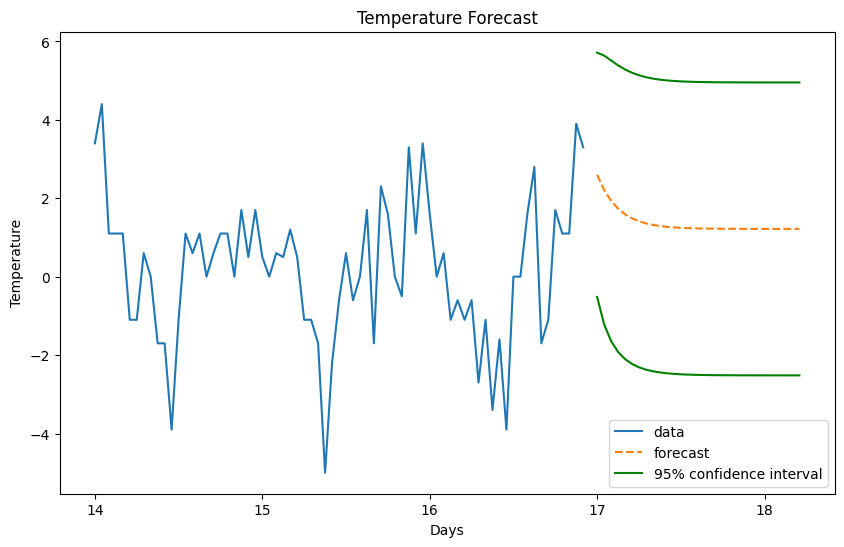

In [57]:
phis, thetas, mu, std = np.array([0.72135856]), np.array([-0.26246788]), 0.35980339870105321, 1.5568331253098422
forcast, variance = arma_forecast(filename='weather.npy', phis=phis, thetas=thetas,
                    mu=mu, std=std, n=30)
data = np.load('weather.npy')
data_diff = np.diff(data)

plt.figure(figsize=(10, 6))

# convert x_axis from hours to days, then plot
x_axis = np.arange(len(data_diff))
x_axis = (x_axis / 24) + 14
plt.plot(x_axis, data_diff, label='data')

# plot forecast, starting at day 17
x_axis = np.arange(30)
x_axis = (x_axis / 24) + 17
plt.plot(x_axis, forcast, '--', label='forecast')

# plot confidence interval with 2 standard deviations
plt.plot(x_axis, forcast + 2 * np.sqrt(variance), 'g-', label='95% confidence interval')
plt.plot(x_axis, forcast - 2 * np.sqrt(variance), 'g-')

plt.xlabel('Days')
plt.ylabel('Temperature')
plt.title('Temperature Forecast')
plt.legend()
plt.show()



## Problem 5

In [80]:
def sm_arma(filename='weather.npy', p_max=3, q_max=3, n=30):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    # load the time series
    time_series = np.diff(np.load(filename))

    # find the best model
    best_aic = np.inf
    best_model = None
    for p in range(1, p_max + 1):
        for q in range(1, q_max + 1):

            # fit the model
            model = ARIMA(time_series,order=(p,0,q),trend='c').fit(method='innovations_mle')

            # find the aic
            aic = model.aic

            if aic < best_aic:
                best_aic = aic
                best_model = model

    # forecast
    forecast = best_model.predict(start=0,end=len(data)+30)

    # plot
    plt.figure(figsize=(10, 6))

    # convert x_axis from hours to days, then plot
    x_axis = np.arange(len(data_diff))
    x_axis = (x_axis / 24) + 14
    plt.plot(x_axis, data_diff, label='data')

    # plote entire forecast
    x_axis = np.arange(len(forecast))
    x_axis = (x_axis / 24) + 14
    plt.plot(x_axis, forecast, '-', label='forecast')
    plt.xlabel('Days')
    plt.ylabel('Temperature')
    plt.title('Temperature Forecast Statsmodel')
    plt.legend()
    plt.show()
                
            



    return best_aic

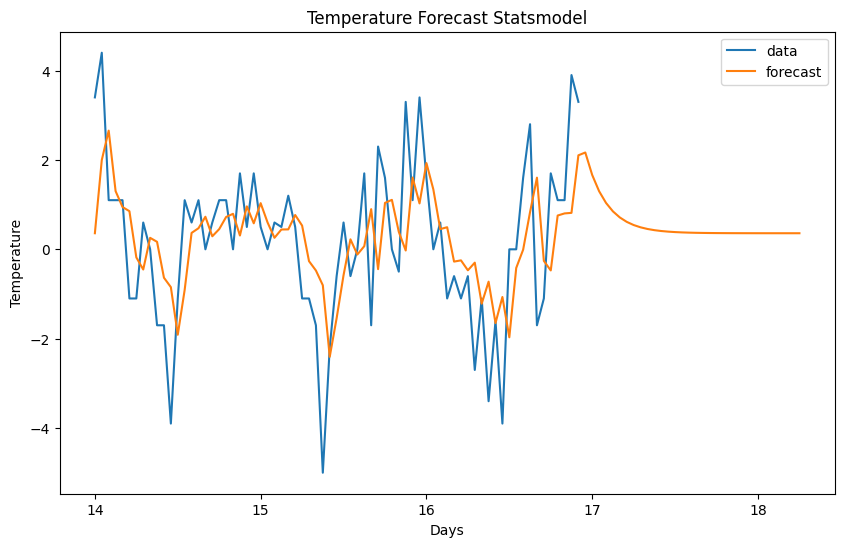

272.7341332617283

In [81]:
sm_arma()

## Problem 6

In [109]:
def sm_varma(start='1959-09-30', end='2012-09-30'):
    """
    Build an VARMAX model with statsmodel and
    forecast from start date until end date.

    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting

    Return:
        aic (float): aic of optimal model
    """
    # Load in data
    df = sm.datasets.macrodata.load_pandas().data
    # Create DatetimeIndex
    dates = df[['year', 'quarter']].astype(int).astype(str)
    dates = dates["year"] + "Q" + dates["quarter"]
    dates = dates_from_str(dates)
    df.index = pd.DatetimeIndex(dates)
    # Select columns used in prediction
    df = df[['realgdp','realcons','realinv']]


    freq = "Q-DEC"

    # Fit the model
    model = VARMAX(df, order=(1,1), trend='c', freq=freq).fit()

    # Forecast
    predict = model.predict(start=start, end=end)
    forecast = model.get_forecast(steps=30)
    all_CI = forecast.conf_int(alpha=0.05)

    # plot
    plt.figure(figsize=(10, 6))

    # plot realgdp and forecast
    plt.plot(df.index, df['realgdp'], label='realgdp')
    plt.plot(predict.index, predict['realgdp'], label='forecast')

    # plot confidence interval
    plt.plot(all_CI.index, all_CI['lower realgdp'], 'k--', label='95% confidence interval')
    plt.plot(all_CI.index, all_CI['upper realgdp'], 'k--')
    plt.xlabel('Date')
    plt.ylabel('Real GDP')
    plt.title('Real GDP Forecast Statsmodel')
    plt.legend()
    plt.show()

    # plot realcons
    plt.plot(df.index, df['realcons'], label='realcons')
    plt.plot(predict.index, predict['realcons'], label='forecast')

    # plot confidence interval
    plt.plot(all_CI.index, all_CI['lower realcons'], 'k--', label='95% confidence interval')
    plt.plot(all_CI.index, all_CI['upper realcons'], 'k--')
    plt.xlabel('Date')
    plt.ylabel('Real Consumption')
    plt.title('Real Consumption Forecast Statsmodel')
    plt.legend()
    plt.show()

    # plot realinv
    plt.plot(df.index, df['realinv'], label='realinv')
    plt.plot(predict.index, predict['realinv'], label='forecast')

    # plot confidence interval
    plt.plot(all_CI.index, all_CI['lower realinv'], 'k--', label='95% confidence interval')
    plt.plot(all_CI.index, all_CI['upper realinv'], 'k--')
    plt.xlabel('Date')
    plt.ylabel('Real Investment')
    plt.title('Real Investment Forecast Statsmodel')
    plt.legend()
    plt.show()


/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49165D+01    |proj g|=  2.09852D+00

At iterate    5    f=  1.47784D+01    |proj g|=  2.09112D-01

At iterate   10    f=  1.47309D+01    |proj g|=  2.11888D+00

At iterate   15    f=  1.46738D+01    |proj g|=  4.88386D-01

At iterate   20    f=  1.46620D+01    |proj g|=  5.47021D-01

At iterate   25    f=  1.46487D+01    |proj g|=  1.27834D-01

At iterate   30    f=  1.46323D+01    |proj g|=  6.82931D-02

At iterate   35    f=  1.46242D+01    |proj g|=  2.00897D-01

At iterate   40    f=  1.46173D+01    |proj g|=  1.54722D-01

At iterate   45    f=  1.46139D+01    |proj g|=  3.78637D-02


/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.46114D+01    |proj g|=  1.73590D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     55      1     0     0   1.736D-01   1.461D+01
  F =   14.611442181183076     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


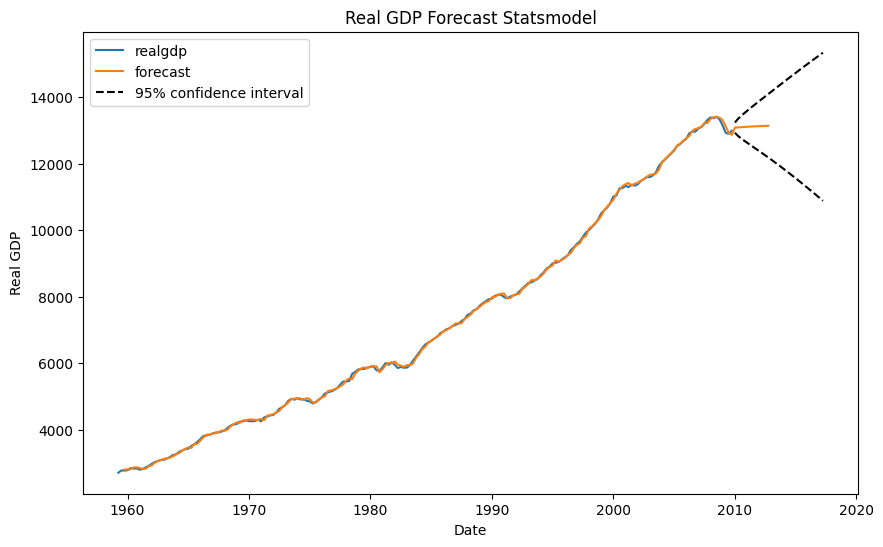

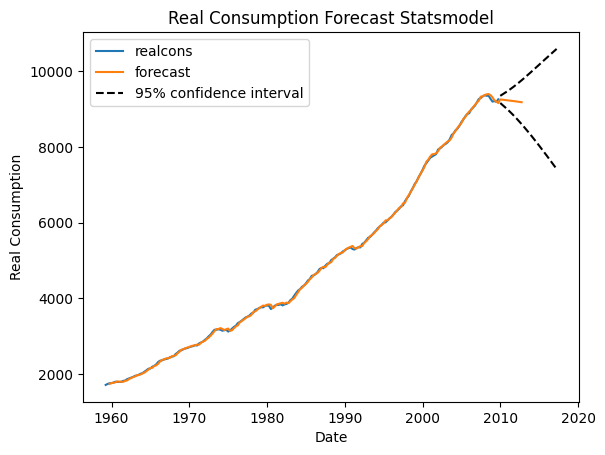

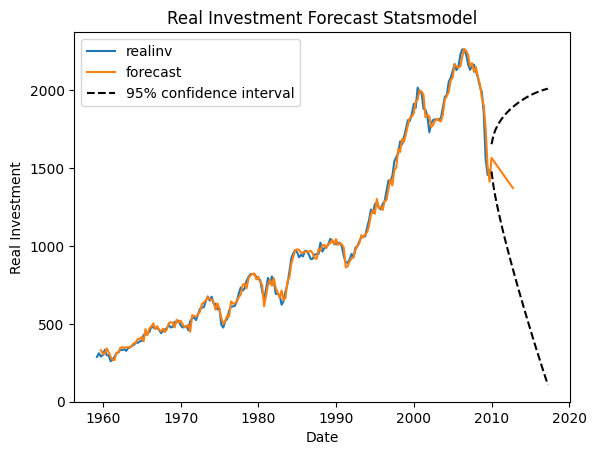

In [110]:
sm_varma()